# Rethinking Statistics course in Stan - Week 4

Lecture 7: Ulysses' Compass

- [Video](https://www.youtube.com/watch?v=0Jc6Kgw5qc0)
- [Slides](https://speakerdeck.com/rmcelreath/l07-statistical-rethinking-winter-2019)

Lecture 8: Model Comparison

- [Video](https://youtu.be/gjrsYDJbRh0)
- [Slides](https://speakerdeck.com/rmcelreath/l08-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week04.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week04_solutions.pdf) for the exercises of the week.

In [1]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from plotnine import *

In [2]:
%load_ext watermark
%watermark -n -u -p pandas,numpy,cmdstanpy,plotnine

Last updated: Fri Dec 31 2021

pandas   : 1.3.4
numpy    : 1.21.4
cmdstanpy: 1.0.0
plotnine : 0.8.0



In [3]:
def waic(stan_fit):
    log_lik = stan_fit.stan_variable('log_lik')
    lppd = np.log(np.exp(log_lik).mean(axis=0)).sum()
    p_waic = np.var(log_lik, axis=0).sum()
    waic = -2*lppd + 2*p_waic
    return round(waic, 3)

## Exercise 1

> Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the birb population. They have each found the following proportions of 5 important birb species:

| island | bird A | bird B | bird C | bird D | bird E |
|--|--|--|--|--|--|
| Island 1 | 0.2 | 0.2 | 0.2  | 0.2   |0.2|
| Island 2 | 0.8 | 0.1 | 0.05 | 0.025 | 0.025|
| Island 3 | 0.05 | 0.15 | 0.7  | 0.05  | 0.05|

> Notice that each row sums to 1, all the birbs. This problem has two parts. It is not computationally complicated. But it is conceptually tricky.
First, compute the entropy of each island's birb distribution. Interpret these entropy values.

> Second, use each island's birb distribution to predict the other two. This means to compute the K-L Divergence of each island from the others, treating each island as if it were a statistical model of the other islands. You should end up with 6 different K-L Divergence values. Which island predicts the others best? Why?

In [4]:
data = [['Island 1', 0.2, 0.2, 0.2, 0.2, 0.2], 
        ['Island 2', 0.8, 0.1, 0.05, 0.025, 0.025], 
        ['Island 3', 0.05, 0.15, 0.7, 0.05, 0.05]] 
df = pd.DataFrame(data, columns = ['Island', 'Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E'])
df

,Island,Bird A,Bird B,Bird C,Bird D,Bird E
0,Island 1,0.20,0.20,0.20,0.200,0.200
1,Island 2,0.80,0.10,0.05,0.025,0.025
2,Island 3,0.05,0.15,0.70,0.050,0.050


The first island has the largest entropy, followed by the third, and then the second in last place. Why is this? Entropy is a measure of the evenness of a distribution. The first islands has the most even distribution of birbs. This means you wouldn’t be very surprised by any particular birb. The second island, in contrast, has a very uneven distribution of birbs. If you saw any birb other than the first species, it would be surprising.

In [5]:
cols = df.columns[1:6]
df['entropy']= -(df[cols]*np.log(df[cols])).sum(axis=1)
df

,Island,Bird A,Bird B,Bird C,Bird D,Bird E,entropy
0,Island 1,0.20,0.20,0.20,0.200,0.200,1.609438
1,Island 2,0.80,0.10,0.05,0.025,0.025,0.743004
2,Island 3,0.05,0.15,0.70,0.050,0.050,0.983600


 Now we need K-L distance, so let’s write a function for it. This is the distance from q to p, regarding p as true and q as the model. Now to use each island as a model of the others, we need to consider the different ordered pairings. The way to read this is each column as a model and each row as a true distribution. So the first island, the first column, the one named `entropy_model1`, has the smaller distances to the other islands. Why does that give it a shorter distance to the other islands? Because it is less surprised by the other islands, due to its high entropy. This makes sense, since it has the highest entropy.

In [6]:
kl_distance = lambda p,q: (p*(np.log(p) - np.log(q))).sum(axis=1)

for i in range(3):
    p = df[cols]
    q = p.loc[i,]
    df[f'entropy_model_{i+1}'] = kl_distance(p,q)
    
df

,Island,Bird A,Bird B,Bird C,Bird D,Bird E,entropy,entropy_model_1,entropy_model_2,entropy_model_3
0,Island 1,0.20,0.20,0.20,0.200,0.200,1.609438,0.000000,0.970406,0.638760
1,Island 2,0.80,0.10,0.05,0.025,0.025,0.743004,0.866434,0.000000,2.010914
2,Island 3,0.05,0.15,0.70,0.050,0.050,0.983600,0.625838,1.838845,0.000000


## Exercise 2

> Recall the marriage, age, and happiness collider bias example from Chapter 6. Run models m6.9 and m6.10 again. Compare these two models using WAIC (or LOO, they will produce identical results). Which model is expected to make better predictions? Which model provides the correct causal inference about the influence of age on happiness? Can you explain why the answers to these two questions disagree?

We start as always getting and processing the data:

In [7]:
d = pd.read_csv('./dat/happiness.csv', header=0)
d.tail(3)

,age,married,happiness
1297,1,0,1.578947
1298,1,0,1.789474
1299,1,0,2.000000


In [8]:
d = d[d.age > 17].copy()
d['age'] = ( d['age'] - 18 ) / ( 65 - 18 )
d['married'] = d['married'].astype('Int64')
d.tail(3)

,age,married,happiness
957,0.0,0,1.578947
958,0.0,0,1.789474
959,0.0,0,2.000000


Model 6.9 from the book:

In [9]:
model = '''
data {
    int n;
    vector[n] happiness;
    vector[n] age;
    int married[n];
}

parameters {
    real a[2];
    real bA;
    real sigma;
}

model {
    // prior
    a ~ normal(0, 1);
    bA ~ normal(0, 2);
    sigma ~ exponential(1);
    // likelihood
    vector[n] mu;
    for (i in 1:n) {
        mu[i] = a[married[i]] + bA * age[i];
    }
    happiness ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = normal_lpdf(happiness[i] | a[married[i]] + bA * age[i], sigma);
  }
}
'''

stan_file = './stn/week04_02a.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)

model_69 = CmdStanModel(stan_file=stan_file)
model_69.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week04_02a.stan to exe file /home/jovyan/work/statret/stn/week04_02a
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week04_02a
INFO:cmdstanpy:found newer exe file, not recompiling


In [10]:
%%time
data = d[['age', 'happiness', 'married']]
data.married = data.married + 1
data = data.to_dict(orient='list')
data['n'] = len(data['age'])
fit_69 = model_69.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 451 ms, sys: 157 ms, total: 608 ms
Wall time: 1.72 s


In [11]:
fit_69.summary().loc[['a[1]', 'a[2]', 'bA', 'sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
a[1],-0.23,0.0017,0.065,-0.34,-0.23,-0.13,1488.0,453.0,1.0
a[2],1.30,0.0023,0.086,1.10,1.30,1.40,1345.0,409.0,1.0
bA,-0.80,0.0000,0.100,-0.90,-0.80,-0.60,1256.2,382.4,1.0
sigma,1.00,0.0000,0.000,1.00,1.00,1.00,2499.6,760.9,1.0


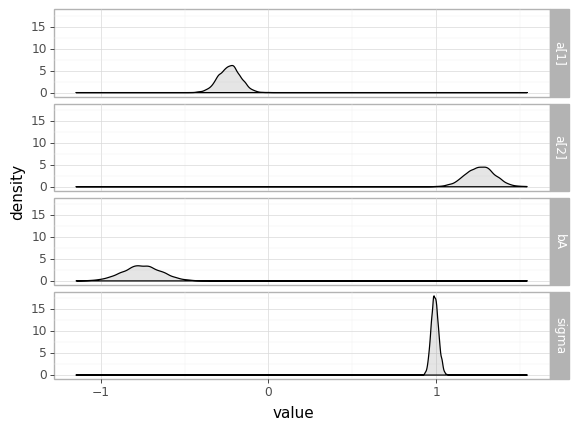

<ggplot: (8741714841754)>

In [12]:
atts = ['bA', 'sigma', 'a']
df = fit_69.draws_pd(vars=atts)
im = pd.melt(df, value_vars=['bA', 'sigma', 'a[1]', 'a[2]'])

(
    ggplot(im)
    + aes(x='value')
    + geom_density(fill='grey', alpha=0.2)
    + theme_light()
    + facet_grid('variable ~ .')
)

Model 6.10 from the book:

In [13]:
model = '''
data {
    int n;
    vector[n] happiness;
    vector[n] age;
}

parameters {
    real a;
    real bA;
    real sigma;
}

model {
    // prior
    a ~ normal(0, 1);
    bA ~ normal(0, 2);
    sigma ~ exponential(1);
    vector[n] mu;
    // likelihood
    for (i in 1:n) {
        mu[i] = a + bA * age[i];
    }
    happiness ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = normal_lpdf(happiness[i] | a + bA * age[i], sigma);
  }
}
'''

stan_file = './stn/week04_02b.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)

model_610 = CmdStanModel(stan_file=stan_file)
model_610.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week04_02b.stan to exe file /home/jovyan/work/statret/stn/week04_02b
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week04_02b
INFO:cmdstanpy:found newer exe file, not recompiling


In [14]:
%%time
data = d[['age', 'happiness']].to_dict(orient='list')
data['n'] = len(data['age'])
fit_610 = model_610.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 585 ms, sys: 126 ms, total: 712 ms
Wall time: 1.8 s


In [15]:
fit_610.summary().loc[['a', 'bA', 'sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
a,-0.00023,0.00190,0.077,-0.13,-0.00051,0.13,1600.0,500.0,1.0
bA,0.00069,0.00340,0.130,-0.22,0.00038,0.22,1500.0,470.0,1.0
sigma,1.20000,0.00057,0.028,1.20,1.20000,1.30,2400.0,750.0,1.0


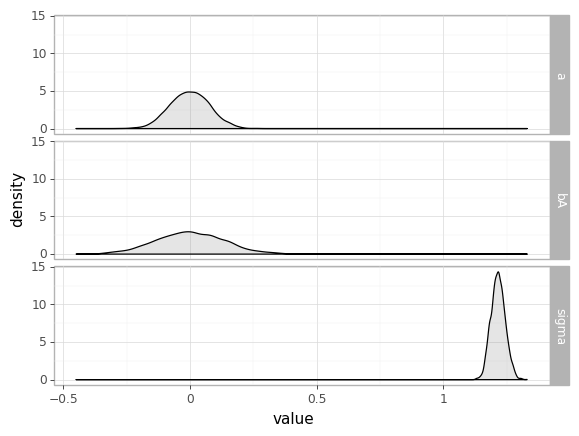

<ggplot: (8741715370234)>

In [16]:
atts = ['a', 'bA', 'sigma']
df = fit_610.draws_pd(vars=atts)
im = pd.melt(df, value_vars=atts)

(
    ggplot(im)
    + aes(x='value')
    + geom_density(fill='grey', alpha=0.2)
    + theme_light()
    + facet_grid('variable ~ .')
)

I won't repeat the models here. They are in the text (_I just did both_). Model m6.9 contains both marriage status and age. Model m6.10 contains only age. Model m6.9 produces a confounded inference about the relationship between age and happiness, due to opening a collider path. The model that produces the invalid inference, m6.9, is expected to predict much better. And it would. This is because the collider path does convey actual association. We simply end up mistaken about the causal inference. We should not use WAIC (or LOO) to choose among models, unless we have some clear sense of the causal model. These criteria will happily favor confounded models.

In [17]:
waic_sc = {
    'model_69' : waic(fit_69),
    'model_610' : waic(fit_610)
}
waic_sc

{'model_69': 2713.725, 'model_610': 3102.094}

## Exercise 3

> Reconsider the urban fox analysis from last week's homework. Use WAIC or LOO based model comparison on five different models, each using `weight` as the outcome, and containing these sets of predictor variables:

>1. `avgfood` + `groupsize` + `area`
2. `avgfood` + `groupsize`
3. `groupsize` + `area`
4. `avgfood`
5. `area`

In [18]:
d = pd.read_csv('./dat/foxes.csv', sep=';', header=0)
d.tail(3)

,group,avgfood,groupsize,area,weight
113,30,0.41,3,1.91,3.16
114,30,0.41,3,1.91,2.78
115,30,0.41,3,1.91,3.86


Standarise the data first of all:

In [19]:
cols = ['avgfood','groupsize','area','weight']
d[cols] = (d[cols] - d[cols].mean())/d[cols].std()
d.tail(3)

,group,avgfood,groupsize,area,weight
113,30,-1.723131,-0.87411,-1.356312,-1.156781
114,30,-1.723131,-0.87411,-1.356312,-1.477721
115,30,-1.723131,-0.87411,-1.356312,-0.565576


Models:

In [20]:
model = '''
data {
    int n;
    vector[n] avgfood;
    vector[n] groupsize;
    vector[n] area;
    vector[n] weight;
}

parameters {
    real a;
    real b[3];
    real sigma;
}

model {
    // prior
    a ~ normal(0, 0.2);
    b ~ normal(0, 0.5);
    sigma ~ exponential(1);
    // likelihood
    vector[n] mu;
    mu = a + b[1]*avgfood + b[2]*groupsize + b[3]*area;
    weight ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = normal_lpdf(weight[i] | a + b[1]*avgfood + b[2]*groupsize + b[3]*area, sigma);
  }
}
'''

stan_file = './stn/week04_03a.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)

model_3a = CmdStanModel(stan_file=stan_file)
model_3a.compile()

data = d[['avgfood', 'groupsize', 'area', 'weight']].to_dict(orient='list')
data['n'] = len(data['weight'])
fit_3a = model_3a.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week04_03a.stan to exe file /home/jovyan/work/statret/stn/week04_03a
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week04_03a
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [21]:
%%time

model = '''
data {
    int n;
    vector[n] avgfood;
    vector[n] groupsize;
    vector[n] weight;
}

parameters {
    real a;
    real b[2];
    real sigma;
}

model {
    // prior
    a ~ normal(0, 0.2);
    b ~ normal(0, 0.5);
    sigma ~ exponential(1);
    // likelihood
    vector[n] mu;
    mu = a + b[1]*avgfood + b[2]*groupsize;
    weight ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = normal_lpdf(weight[i] | a + b[1]*avgfood + b[2]*groupsize, sigma);
  }
}
'''

stan_file = './stn/week04_03b.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)

model_3b = CmdStanModel(stan_file=stan_file)
model_3b.compile()

data = d[['avgfood', 'groupsize', 'weight']].to_dict(orient='list')
data['n'] = len(data['weight'])
fit_3b = model_3b.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week04_03b.stan to exe file /home/jovyan/work/statret/stn/week04_03b
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week04_03b
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 243 ms, sys: 134 ms, total: 377 ms
Wall time: 13.4 s


In [22]:
%%time

model = '''
data {
    int n;
    vector[n] avgfood;
    vector[n] area;
    vector[n] weight;
}

parameters {
    real a;
    real b[2];
    real sigma;
}

model {
    // prior
    a ~ normal(0, 0.2);
    b ~ normal(0, 0.5);
    sigma ~ exponential(1);
    // likelihood
    vector[n] mu;
    mu = a + b[1]*avgfood + b[2]*area;
    weight ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = normal_lpdf(weight[i] | a + b[1]*avgfood + b[2]*area, sigma);
  }
}
'''

stan_file = './stn/week04_03c.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)

model_3c = CmdStanModel(stan_file=stan_file)
model_3c.compile()

data = d[['avgfood', 'area', 'weight']].to_dict(orient='list')
data['n'] = len(data['weight'])
fit_3c = model_3c.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week04_03c.stan to exe file /home/jovyan/work/statret/stn/week04_03c
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week04_03c
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 242 ms, sys: 142 ms, total: 384 ms
Wall time: 13.7 s


In [23]:
%%time

model = '''
data {
    int n;
    vector[n] avgfood;
    vector[n] weight;
}

parameters {
    real a;
    real b;
    real sigma;
}

model {
    // prior
    a ~ normal(0, 0.2);
    b ~ normal(0, 0.5);
    sigma ~ exponential(1);
    // likelihood
    vector[n] mu;
    mu = a + b*avgfood;
    weight ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = normal_lpdf(weight[i] | a + b*avgfood, sigma);
  }
}
'''

stan_file = './stn/week04_03d.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)

model_3d = CmdStanModel(stan_file=stan_file)
model_3d.compile()

data = d[['avgfood', 'weight']].to_dict(orient='list')
data['n'] = len(data['weight'])
fit_3d = model_3d.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week04_03d.stan to exe file /home/jovyan/work/statret/stn/week04_03d
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week04_03d
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 217 ms, sys: 143 ms, total: 360 ms
Wall time: 11.9 s


In [24]:
%%time

model = '''
data {
    int n;
    vector[n] area;
    vector[n] weight;
}

parameters {
    real a;
    real b;
    real sigma;
}

model {
    // prior
    a ~ normal(0, 0.2);
    b ~ normal(0, 0.5);
    sigma ~ exponential(1);
    // likelihood
    vector[n] mu;
    mu = a + b*area;
    weight ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  for (i in 1:n) {
    log_lik[i] = normal_lpdf(weight[i] | a + b*area, sigma);
  }
}
'''

stan_file = './stn/week04_03e.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)

model_3e = CmdStanModel(stan_file=stan_file)
model_3e.compile()

data = d[['area', 'weight']].to_dict(orient='list')
data['n'] = len(data['weight'])
fit_3e = model_3e.sample(data=data, chains=4)

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week04_03e.stan to exe file /home/jovyan/work/statret/stn/week04_03e
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week04_03e
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 242 ms, sys: 132 ms, total: 374 ms
Wall time: 11.1 s


In [25]:
sc = {
    '1' : waic(fit_3a),
    '2' : waic(fit_3b),
    '3' : waic(fit_3c),
    '4' : waic(fit_3d),
    '5' : waic(fit_3e),
}
scores = pd.DataFrame(sc.items(), columns=['model','waic'])
scores.sort_values(by='waic')

,model,waic
4,5,72997.241
2,3,74760.620
3,4,74849.988
1,2,83245.826
0,1,89155.048


The variables of the models were the following ones:
1. `avgfood` + `groupsize` + `area`
2. `avgfood` + `groupsize`
3. `groupsize` + `area`
4. `avgfood`
5. `area`

To remind you, the DAG from last week is:

<img src="./fig/w1_img1.png" width="60%">

Notice that the last models are m1 and m2. They have very similar WAIC values. This makes sense, given the DAG, because the influence of `area` is routed entirely through `avgfood` and `groupsize`. There are no back-door paths.

What about the other two models, m4 and m5? These models are tied with one another, and both omit `groupsize`. Again, the influence of `area` passes entirely through `avgfood`. So including only `avgfood` or only `area` should produce the same inference; the total causal influence of `area` (or `avgfood`) is just about zero. That's indeed what the posterior distributions suggest:

In [26]:
fit_3d.summary().loc[['a','b','sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
a,0.00029,0.0013,0.086,-0.14,-0.00097,0.14,4300.0,6600.0,1.0
b,-0.02300,0.0015,0.093,-0.17,-0.02500,0.13,4000.0,6100.0,1.0
sigma,1.00000,0.0011,0.067,0.90,1.00000,1.10,3600.0,5500.0,1.0


In [27]:
fit_3e.summary().loc[['a','b','sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
a,-0.00079,0.0013,0.085,-0.14,-0.00023,0.14,4300.0,6700.0,1.0
b,0.01800,0.0015,0.092,-0.14,0.02000,0.17,3800.0,5800.0,1.0
sigma,1.00000,0.0010,0.066,0.91,1.00000,1.10,4000.0,6100.0,1.0
